# Data Collection

In [ ]:
pip install textblob
pip install selenium
pip install webdriver_manager
pip install dateparser

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import os
import yfinance as yf
import math
import warnings
warnings.filterwarnings("ignore")

In [3]:
import nltk
from matplotlib.dates import DateFormatter
import statistics

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
import time

From Yahoo Finance Using Selenium

In [ ]:
# Setup Selenium WebDriver
service = Service(ChromeDriverManager().install())
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")  # Enable headless mode
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(service=service, options=chrome_options)

tickers = ['TSLA', 'SMCI', 'AMZN', 'AVGO', 'ALB', 'AAPL']

def last_12_months(time_text):
    if 'months' in time_text:
        months = int(time_text.split()[0])
        return months <= 12
    return True

# Initialize an empty DataFrame to collect all news
headlines = pd.DataFrame()

for ticker in tickers:
    url = f'https://finance.yahoo.com/quote/{ticker}/news/'
    driver.get(url)
    time.sleep(4)
    print(f'Collecting news related to {ticker}')
    previous_height = driver.execute_script('return document.body.scrollHeight')
    count = 0
    news = []
    
    while True:
        content_divs = driver.find_elements(By.CSS_SELECTOR, 'div.content.svelte-w27v8j')
        
        latest_time_text = ''
        for content_div in content_divs:
            try:
                a_tag = content_div.find_element(By.CSS_SELECTOR, 'a.subtle-link.fin-size-small.titles.noUnderline.svelte-wdkn18')
                title = a_tag.get_attribute('title') if a_tag else None
                
                publishing_div = content_div.find_element(By.CSS_SELECTOR, 'div.publishing.font-condensed.svelte-1k3af9g')
                time_text = publishing_div.text.split('•')[-1].strip() if publishing_div else None
                latest_time_text = time_text
                if latest_time_text and last_12_months(latest_time_text):
                    news.append({'Date': time_text, 'Headline': title, 'Stock Name': ticker})
            except Exception as e:
                print(f"Error extracting data: {e}")

        driver.execute_script('window.scrollTo(0, document.body.scrollHeight)')
        time.sleep(4)
        new_height = driver.execute_script('return document.body.scrollHeight')
        
        if new_height == previous_height:
            count += 1
            if count > 4:
                break
        else:
            previous_height = new_height
            count = 0
        
        if latest_time_text and not last_12_months(latest_time_text):
            break
    
    df_news = pd.DataFrame(news)
    
    if not df_news.empty:
        print(f'Starting news related to {ticker} is {df_news["Date"].iloc[0]}')
        print(f'Ending news related to {ticker} is {df_news["Date"].iloc[-1]}')
        print('Dataset size is ', df_news.shape[0])
        headlines = pd.concat([headlines, df_news], ignore_index=True)

# Close the WebDriver
driver.quit()

<IPython.core.display.Javascript object>

In [ ]:
headlines.head()

In [ ]:
from textblob import TextBlob, Word
from datetime import datetime, timedelta
import time

In [ ]:
# Function to convert relative time text to actual date
def convert_to_date(time_text):
    now = datetime.now()
    if time_text == 'yesterday':
        return now - timedelta(days=1)
    if time_text == 'last month':
        return now - timedelta(days=30)
    if 'minute' in time_text:
        minutes = int(time_text.split()[0])
        return now - timedelta(minutes=minutes)
    elif 'hour' in time_text:
        hours = int(time_text.split()[0])
        return now - timedelta(hours=hours)
    elif 'day' in time_text:
        days = int(time_text.split()[0])
        return now - timedelta(days=days)
    elif 'week' in time_text:
        weeks = int(time_text.split()[0])
        return now - timedelta(weeks=weeks)
    elif 'month' in time_text:
        months = int(time_text.split()[0])
        return now - timedelta(days=30*months)
    elif 'today' in time_text.lower():
        return now
    else:
        return None
headlines['Date'] = headlines['Date'].apply(convert_to_date)

From New York Times

In [ ]:
import pandas as pd
import requests
import time

In [ ]:
def fetch_data(year, month, api_key):
    url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        articles = data['response']['docs']
        return articles
    else:
        print(f"Failed to fetch data for {year}-{month}: {response.status_code}")
        return []

# Initialize lists for headlines and dates
all_headlines = []
all_dates = []

# API key
api_key = ''

# Fetch data for each year from 2010 to 2024
for year in range(2019, 2025):
    for month in range(1, 13):
        print(f"Fetching data for {year}-{month}")
        try:
            articles = fetch_data(year, month, api_key)
            if articles:
                all_headlines.extend([article['headline']['main'] for article in articles])
                all_dates.extend([article['pub_date'] for article in articles])
            # Sleep to respect API rate limits
            time.sleep(6)  # Adjust sleep time as needed based on API rate limits
        except Exception as e:
            print(f"Error fetching data for {year}-{month}: {e}")

# Create a DataFrame
df = pd.DataFrame({'datetime': all_dates, 'news': all_headlines})

# Convert datetime column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract date
df['date'] = df['datetime'].dt.date

# Filter articles containing information about Apple company stock
keywords = ['Apple', 'AAPL', 'Apple Inc', 'Apple stock', 'Apple shares']
df['contains_apple_stock_info'] = df['news'].apply(lambda x: any(keyword in x for keyword in keywords))

# Create a filtered DataFrame
apple_stock_df = df[df['contains_apple_stock_info']]

# Group by date and concatenate news articles
apple_df = apple_stock_df.groupby('date')['news'].agg(' '.join).reset_index()

# Rename columns and convert Date to datetime format
apple_df.columns = ['Date', 'news_articles']
apple_df['Date'] = pd.to_datetime(apple_df['Date'])

# Print the resulting DataFrame
print(apple_df)


Fetching data for 2019-1
Fetching data for 2019-2


In [ ]:
apple_df.rename(columns={'news_articles': 'Headline'}, inplace=True)
stock_name = 'AAPL'  # Replace with the actual stock name
apple_df['Stock Name'] = stock_name

In [16]:
apple_df.shape

(282, 2)

In [30]:
headlines.head()

,Date,Headline,Stock Name
0,16 hours ago,"Bullish S&P 500 calls, weak China industrial o...",TSLA
1,18 hours ago,Tesla's 'aging portfolio' is a bigger issue th...,TSLA
2,59 minutes ago,Warren Buffett’s Berkshire Hathaway dumps BYD ...,TSLA
3,1 hour ago,"Trending tickers: Apple, Palantir, Tesla and W...",TSLA
4,3 hours ago,Musk plans stock option grants to Tesla's high...,TSLA


In [6]:
headlines.tail()

,Date,Headline,Stock Name
6965,6 days ago,Apple’s AI: We’ve seen some of this before,AAPL
6966,6 days ago,"S&P 500, Nasdaq Extend Rallies Ahead of Fed De...",AAPL
6967,6 days ago,Apple Stock Closes at a New High. Investors Li...,AAPL
6968,6 days ago,Apple’s Stock Finished the Day at a Record High,AAPL
6969,6 days ago,Apple Stock (NASDAQ:AAPL): Still a Golden Oppo...,AAPL


In [7]:
headlines.shape

(6970, 3)

Stock Price data from Yahoo Finance

In [9]:
tickers = ['TSLA', 'SMCI', 'AMZN', 'AVGO', 'ALB', 'AAPL']
Stock=pd.DataFrame()  # Example ticker symbol for Apple
start_date = "2018-07-01"  # Specify start date
end_date = "2024-06-14"   
dfs = [] 
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date).reset_index()  # Reset index to make 'Date' a column
    data['Stock Name'] = ticker  # Add a column for the ticker symbol
    dfs.append(data)

# Combine all individual dataframes into a single dataframe
Stock = pd.concat(dfs, ignore_index=True)

# Reorder columns as per the desired format
Stock = Stock[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Stock Name']]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [32]:
Stock["Date"] = pd.to_datetime(Stock['Date'])
Stock["Date"] = Stock["Date"].dt.date
Stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Pct Change
0,2018-07-02,24.004667,24.318666,21.990000,22.337999,22.337999,281397000,TSLA,NaN
1,2018-07-03,22.116667,22.166000,20.646000,20.724001,20.724001,184239000,TSLA,-7.225349
2,2018-07-05,20.917334,20.959333,19.747999,20.610666,20.610666,262146000,TSLA,-0.546876
3,2018-07-06,20.330000,20.804667,20.133333,20.593332,20.593332,132982500,TSLA,-0.084102
4,2018-07-09,20.799334,21.234667,20.533333,21.233999,21.233999,113952000,TSLA,3.111041


In [10]:
Stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2018-07-02,24.004667,24.318666,21.990000,22.337999,22.337999,281397000,TSLA
1,2018-07-03,22.116667,22.166000,20.646000,20.724001,20.724001,184239000,TSLA
2,2018-07-05,20.917334,20.959333,19.747999,20.610666,20.610666,262146000,TSLA
3,2018-07-06,20.330000,20.804667,20.133333,20.593332,20.593332,132982500,TSLA
4,2018-07-09,20.799334,21.234667,20.533333,21.233999,21.233999,113952000,TSLA


In [15]:
Stock['Pct Change'] = Stock.groupby('Stock Name')['Adj Close'].pct_change() * 100

In [16]:
Stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Pct Change
0,2018-07-02,24.004667,24.318666,21.990000,22.337999,22.337999,281397000,TSLA,NaN
1,2018-07-03,22.116667,22.166000,20.646000,20.724001,20.724001,184239000,TSLA,-7.225349
2,2018-07-05,20.917334,20.959333,19.747999,20.610666,20.610666,262146000,TSLA,-0.546876
3,2018-07-06,20.330000,20.804667,20.133333,20.593332,20.593332,132982500,TSLA,-0.084102
4,2018-07-09,20.799334,21.234667,20.533333,21.233999,21.233999,113952000,TSLA,3.111041


In [12]:
Stock['Stock Name'].value_counts()

Stock Name
TSLA    240
SMCI    240
AMZN    240
AVGO    240
ALB     240
AAPL    240
Name: count, dtype: int64

In [24]:
Stock.shape

(2400, 8)

In [18]:
print(headlines['Stock Name'].unique())

['TSLA' 'SMCI' 'AMZN' 'AVGO' 'ALB' 'AAPL']


In [19]:
headlines.shape

(6970, 3)

Concating all Collected Data

In [61]:
headlines = pd.concat([headlines, apple_df], ignore_index=True)

## Calculating Polarity Score for Sentiment analysis

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

In [33]:
headlines['polarity_score']=''
headlines.head()

,Date,Headline,Stock Name,polarity_score
0,2024-06-19 22:16:07.654294,"Bullish S&P 500 calls, weak China industrial o...",TSLA,
1,2024-06-19 20:16:07.654294,Tesla's 'aging portfolio' is a bigger issue th...,TSLA,
2,2024-06-20 13:17:07.654294,Warren Buffett’s Berkshire Hathaway dumps BYD ...,TSLA,
3,2024-06-20 13:16:07.654294,"Trending tickers: Apple, Palantir, Tesla and W...",TSLA,
4,2024-06-20 11:16:07.654294,Musk plans stock option grants to Tesla's high...,TSLA,


In [34]:
sent_analyze = SentimentIntensityAnalyzer()

# Analyze each tweet and store the compound score
for ind, row in headlines.iterrows():
    sentence_i = unicodedata.normalize("NFKD", row["Headline"])
    sent_sent = sent_analyze.polarity_scores(sentence_i)
    headlines.at[ind, "polarity_score"] = sent_sent["compound"]

In [48]:
headlines.head()

,Date,Headline,Stock Name,polarity_score,pct_change
0,2024-06-19,"Bullish S&P 500 calls, weak China industrial o...",TSLA,-0.4404,0.222089
1,2024-06-19,Tesla's 'aging portfolio' is a bigger issue th...,TSLA,0.0,0.222089
2,2024-06-20,Warren Buffett’s Berkshire Hathaway dumps BYD ...,TSLA,-0.4215,0.222089
3,2024-06-20,"Trending tickers: Apple, Palantir, Tesla and W...",TSLA,0.0,0.222089
4,2024-06-20,Musk plans stock option grants to Tesla's high...,TSLA,0.2263,0.222089


# Labeling headlines with pct_change calculated from stock prices

In [46]:
# Create a dictionary to map (Date, Stock Name) to Pct Change
pct_change_dict = Stock.set_index(['Date', 'Stock Name'])['Pct Change'].to_dict()

# Assign Pct Change values to headlines_df
headlines['pct_change'] = headlines.apply(lambda row: pct_change_dict.get((row['Date'], row['Stock Name']), None), axis=1)

# Calculate mean Pct Change for each Stock Name
mean_pct_change = Stock.groupby('Stock Name')['Pct Change'].mean().to_dict()

# Fill NaN values with the mean Pct Change of the respective company
headlines['pct_change'] = headlines.apply(lambda row: mean_pct_change[row['Stock Name']] if pd.isna(row['pct_change']) else row['pct_change'], axis=1)

In [47]:
na_count = headlines['pct_change'].isna().sum()
print(f"Number of NaN values in 'pct_change' column: {na_count}")

Number of NaN values in 'pct_change' column: 0


In [49]:
headlines.head()

,Date,Headline,Stock Name,polarity_score,pct_change
0,2024-06-19,"Bullish S&P 500 calls, weak China industrial o...",TSLA,-0.4404,0.222089
1,2024-06-19,Tesla's 'aging portfolio' is a bigger issue th...,TSLA,0.0,0.222089
2,2024-06-20,Warren Buffett’s Berkshire Hathaway dumps BYD ...,TSLA,-0.4215,0.222089
3,2024-06-20,"Trending tickers: Apple, Palantir, Tesla and W...",TSLA,0.0,0.222089
4,2024-06-20,Musk plans stock option grants to Tesla's high...,TSLA,0.2263,0.222089


In [50]:
headlines["Date"] = pd.to_datetime(headlines['Date'])
headlines["Date"] = headlines["Date"].dt.date
headlines.head()

,Date,Headline,Stock Name,polarity_score,pct_change
0,2024-06-19,"Bullish S&P 500 calls, weak China industrial o...",TSLA,-0.4404,0.222089
1,2024-06-19,Tesla's 'aging portfolio' is a bigger issue th...,TSLA,0.0,0.222089
2,2024-06-20,Warren Buffett’s Berkshire Hathaway dumps BYD ...,TSLA,-0.4215,0.222089
3,2024-06-20,"Trending tickers: Apple, Palantir, Tesla and W...",TSLA,0.0,0.222089
4,2024-06-20,Musk plans stock option grants to Tesla's high...,TSLA,0.2263,0.222089


In [56]:
headlines['label'] = headlines['pct_change'].apply(lambda x: 2 if x > 0 else (1 if x == 0 else 0))
headlines.head()

,Date,Headline,Stock Name,polarity_score,pct_change,label
0,2024-06-19,"Bullish S&P 500 calls, weak China industrial o...",TSLA,-0.4404,0.222089,2
1,2024-06-19,Tesla's 'aging portfolio' is a bigger issue th...,TSLA,0.0,0.222089,2
2,2024-06-20,Warren Buffett’s Berkshire Hathaway dumps BYD ...,TSLA,-0.4215,0.222089,2
3,2024-06-20,"Trending tickers: Apple, Palantir, Tesla and W...",TSLA,0.0,0.222089,2
4,2024-06-20,Musk plans stock option grants to Tesla's high...,TSLA,0.2263,0.222089,2


In [69]:
headlines["sentiment_label"].value_counts()

sentiment_label
2    3414
1    2848
0     990
Name: count, dtype: int64

In [31]:
headlines.shape

(6970, 5)

# Preprocessing and Training

In [ ]:
# Preprocessing function
def preprocessing(df):
    # Convert to lower case
    df = df.str.lower()
    # Remove punctuation
    df = df.str.replace('[^\w\s]', '', regex=True)
    # Remove numbers
    df = df.str.replace('\d', '', regex=True)
    # Remove stopwords
    sw = stopwords.words('english')
    df = df.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
    # Remove infrequent words
    temp_df = pd.Series(' '.join(df).split()).value_counts()
    drops = temp_df[temp_df <= 1]
    df = df.apply(lambda x: " ".join(x for x in x.split() if x not in drops))
    return df

# Tokenization function
def tokenization(df):
    df = df.apply(lambda x: TextBlob(x).words)
    return df

# Lemmatization function
def lemmatized(df):
    df = df.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return df

In [ ]:
# Term frequency function
def term_fre(df):
    tf = df.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
    tf.columns = ['words', 'tf']
    tf_sorted = tf.sort_values(by='tf', ascending=False)
    return tf_sorted

# TF-IDF function
def tfidf(X, fit_vectorizer=None):
    if fit_vectorizer is None:
        fit_vectorizer = TfidfVectorizer()
        X_tf_idf_word = fit_vectorizer.fit_transform(X)
    else:
        X_tf_idf_word = fit_vectorizer.transform(X)
    return X_tf_idf_word, fit_vectorizer

# Function to preprocess and vectorize
def finalX(X, vectorizer=None):
    # Apply preprocessing
    X = preprocessing(X)

    # Apply tokenization (if needed)
    # X = tokenization(X)

    # Apply lemmatization
    X = lemmatized(X)

    # Convert to TF-IDF
    X_tf_idf_word, vectorizer = tfidf(X, vectorizer)
    return X_tf_idf_word, vectorizer

In [ ]:
X = headlines[['Headline','polarity_score']]
y = headlines['label']
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Convert to TF-IDF
X_tf_idf_word_train, vectorizer = finalX(X_train['Headline'])

X_tf_idf_word_test, _ = finalX(X_test['Headline'], vectorizer)

# Train RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_tf_idf_word_train, y_train)


RandomForestClassifier()

ROC Curve for Random Forest Model

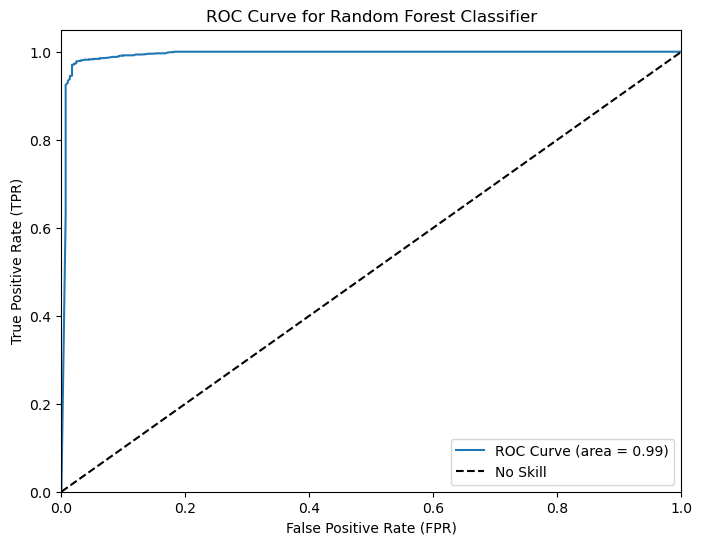

In [83]:
from sklearn.metrics import roc_curve, auc
y_train = np.where(y_train >= 2, 1, 0)
y_test = np.where(y_test >= 2, 1, 0)


# Predict probabilities using the trained model
y_pred_proba = rf_model.predict_proba(X_tf_idf_word_test)[:, 1]  # Select probability for positive class

# Calculate ROC curve metrics
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend()
plt.show()


In [72]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import numpy as np


# List of classifiers to evaluate
classifiers = [
    ('GaussianNB', GaussianNB()),
    ('MultinomialNB', MultinomialNB()),
    ('BernoulliNB', BernoulliNB()),
    ('LogisticRegression', LogisticRegression(max_iter=1000)),
    ('SVC', SVC(probability=True)),
    ('DecisionTree', DecisionTreeClassifier()),
    ('KNeighbors', KNeighborsClassifier(n_neighbors=5)),
    ('RandomForest', RandomForestClassifier(n_estimators=100)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=100)),
    ('Bagging', BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=100)),
    ('GradientBoosting', GradientBoostingClassifier(n_estimators=100)),
]

# Evaluate each classifier
for name, clf in classifiers:
    print(f"Evaluating {name}...")
    # Fit the model on the scaled training data
    X_tf_idf_word_train, vectorizer = givefinalX(X_train['Headline'])

    X_tf_idf_word_test, _ = givefinalX(X_test['Headline'], vectorizer)
    clf.fit(X_tf_idf_word_train.toarray(), y_train)
    
    # Predict the test set results
    y_pred = clf.predict(X_tf_idf_word_test.toarray())
    
    # Calculate and print evaluation metrics
    cv_score = cross_val_score(clf, X_tf_idf_word_train.toarray(), y_train, cv=5).mean()
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, average='weighted')
    test_recall = recall_score(y_test, y_pred, average='weighted')
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Cross-validation score: {cv_score:.6f}")
    print(f"Test set accuracy: {test_accuracy:.6f}")
    print(f"Precision: {test_precision:.6f}")
    print(f"Recall: {test_recall:.6f}")
    print(f"F1 Score: {test_f1:.6f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")


Evaluating GaussianNB...
Cross-validation score: 0.888809
Test set accuracy: 0.852941
Precision: 0.913599
Recall: 0.852941
F1 Score: 0.864505
Confusion Matrix:
 [[292   0]
 [205 897]]


Evaluating MultinomialNB...
Cross-validation score: 0.904948
Test set accuracy: 0.911047
Precision: 0.908823
Recall: 0.911047
F1 Score: 0.906674
Confusion Matrix:
 [[ 197   95]
 [  29 1073]]


Evaluating BernoulliNB...
Cross-validation score: 0.879840
Test set accuracy: 0.866571
Precision: 0.893200
Recall: 0.866571
F1 Score: 0.873735
Confusion Matrix:
 [[255  37]
 [149 953]]


Evaluating LogisticRegression...
Cross-validation score: 0.893653
Test set accuracy: 0.905308
Precision: 0.902101
Recall: 0.905308
F1 Score: 0.901460
Confusion Matrix:
 [[ 198   94]
 [  38 1064]]


Evaluating SVC...
Cross-validation score: 0.989958
Test set accuracy: 0.982783
Precision: 0.982704
Recall: 0.982783
F1 Score: 0.982695
Confusion Matrix:
 [[ 276   16]
 [   8 1094]]


Evaluating DecisionTree...
Cross-validation score: 0.

In [60]:
 # Cross-validation score
cv_score = cross_val_score(rf_model, X_tf_idf_word_train, y_train, cv=5, n_jobs=-1).mean()
print(f"Cross-validation score: {cv_score}")


Cross-validation score: 0.9958747609174342


In [61]:
 # Predictions on test set
pred = rf_model.predict(X_tf_idf_word_test)
print(f"Test set predictions: {pred}")


Test set predictions: [2 2 0 ... 2 0 2]


In [62]:
# Evaluate on the test set
test_score = rf_model.score(X_tf_idf_word_test, y_test)
print(f"Test set score: {test_score}")

Test set score: 0.9741750358680057


# Trading Strategy

In [133]:
df = headlines[["Date","polarity_score","Stock Name"]]
df.head()

,Date,polarity_score,Stock Name
0,2024-06-17,-0.4404,TSLA
1,2024-06-17,0.0,TSLA
2,2024-06-18,-0.4215,TSLA
3,2024-06-18,0.0,TSLA
4,2024-06-18,0.2263,TSLA


In [121]:
df.shape

(7252, 3)

In [72]:
df["Stock Name"].value_counts()

Stock Name
AAPL    1512
ALB     1220
AMZN    1140
AVGO    1140
TSLA    1120
SMCI    1120
Name: count, dtype: int64

In [134]:
# Group by "Date" and "Stock Name" and calculate the mean of "sentence_score"
df_grouped = df.groupby(["Date", "Stock Name"]).mean().reset_index()

In [123]:
print(df_grouped.shape)

(386, 3)


In [124]:
df_grouped.head()

,Date,Stock Name,polarity_score
0,2020-01-02,AAPL,0.6369
1,2020-01-07,AAPL,0.4019
2,2020-01-13,AAPL,0.0
3,2020-01-14,AAPL,0.0
4,2020-01-16,AAPL,-0.7269


In [76]:
df_grouped['Stock Name'].value_counts()

Stock Name
AAPL    289
SMCI     29
AVGO     28
ALB      20
AMZN     14
TSLA      6
Name: count, dtype: int64

In [77]:
df_grouped.columns

Index(['Date', 'Stock Name', 'polarity_score'], dtype='object')

In [125]:
print(Stock.shape)
Stock.head()

(8988, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2018-07-02,24.004667,24.318666,21.990000,22.337999,22.337999,281397000,TSLA
1,2018-07-03,22.116667,22.166000,20.646000,20.724001,20.724001,184239000,TSLA
2,2018-07-05,20.917334,20.959333,19.747999,20.610666,20.610666,262146000,TSLA
3,2018-07-06,20.330000,20.804667,20.133333,20.593332,20.593332,132982500,TSLA
4,2018-07-09,20.799334,21.234667,20.533333,21.233999,21.233999,113952000,TSLA


In [79]:
Stock['Stock Name'].value_counts()

Stock Name
TSLA    1498
SMCI    1498
AMZN    1498
AVGO    1498
ALB     1498
AAPL    1498
Name: count, dtype: int64

In [49]:
Stock['Stock Name'].unique()

array(['TSLA', 'SMCI', 'AMZN', 'AVGO', 'ALB', 'AAPL'], dtype=object)

In [131]:
Stock["Date"]=pd.to_datetime(Stock["Date"])
Stock["Date"]=Stock["Date"].dt.date
print(Stock.shape)
Stock.head()

(8988, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2018-07-02,24.004667,24.318666,21.990000,22.337999,22.337999,281397000,TSLA
1,2018-07-03,22.116667,22.166000,20.646000,20.724001,20.724001,184239000,TSLA
2,2018-07-05,20.917334,20.959333,19.747999,20.610666,20.610666,262146000,TSLA
3,2018-07-06,20.330000,20.804667,20.133333,20.593332,20.593332,132982500,TSLA
4,2018-07-09,20.799334,21.234667,20.533333,21.233999,21.233999,113952000,TSLA


# Sentiment Adjusted Moving Score Analysis for Apple

In [127]:
stk_name='AAPL'

In [128]:
stock = Stock[Stock["Stock Name"] == stk_name]
stock["Date"] = pd.to_datetime(stock["Date"])
stock["Date"] = stock["Date"].dt.date
# Reset the index of appl_stock
stock.reset_index(drop=True, inplace=True)
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2018-07-02,45.955002,46.825001,45.855000,46.794998,44.544914,70925200,AAPL
1,2018-07-03,46.947498,46.987499,45.884998,45.980000,43.769100,55819200,AAPL
2,2018-07-05,46.314999,46.602501,46.070000,46.349998,44.121304,66416800,AAPL
3,2018-07-06,46.355000,47.107498,46.299999,46.992500,44.732925,69940800,AAPL
4,2018-07-09,47.375000,47.669998,47.325001,47.645000,45.354042,79026400,AAPL


In [83]:
stock.shape

(1498, 8)

In [129]:
# Now filter the grouped DataFrame for rows where 'Stock Name' is 'AAPL'
df = df_grouped[df_grouped['Stock Name'] == stk_name]
# Reset the index of appl_df
df.reset_index(drop=True, inplace=True)

In [130]:
print(df.shape)
df.head()

(289, 3)


,Date,Stock Name,polarity_score
0,2020-01-02,AAPL,0.6369
1,2020-01-07,AAPL,0.4019
2,2020-01-13,AAPL,0.0
3,2020-01-14,AAPL,0.0
4,2020-01-16,AAPL,-0.7269


In [135]:
# Now perform the join operation
df = stock.join(df.set_index(["Date", "Stock Name"]), on=["Date", "Stock Name"], how="inner")
df.reset_index(drop=True, inplace=True)

In [136]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,polarity_score
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400,AAPL,0.6369
1,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000,AAPL,0.4019
2,2020-01-13,77.910004,79.267502,77.787498,79.239998,77.099754,121532000,AAPL,0.0
3,2020-01-14,79.175003,79.392502,78.042503,78.169998,76.058670,161954400,AAPL,0.0
4,2020-01-16,78.397499,78.925003,78.022499,78.809998,76.681396,108829200,AAPL,-0.7269


In [137]:
df.shape

(706, 9)

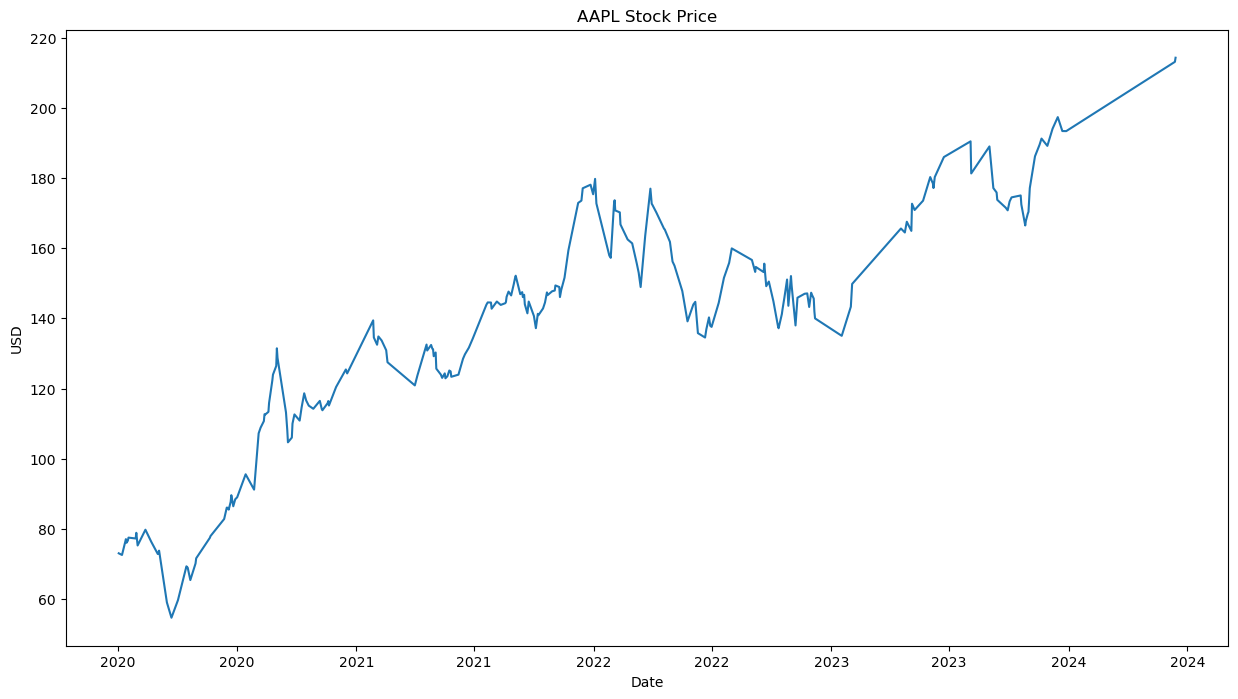

In [138]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(df["Date"], df["Adj Close"])
ax.set(xlabel="Date",ylabel="USD",title=f"{stk_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

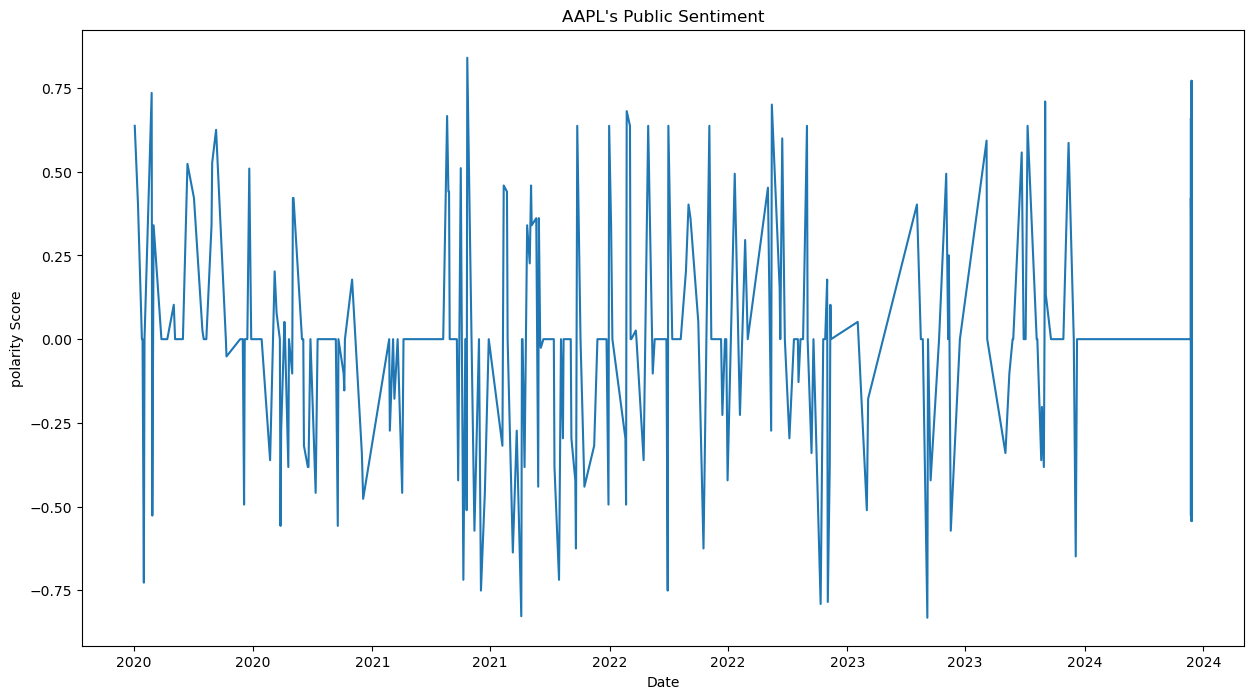

In [139]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(df["Date"], df["polarity_score"])
ax.set(xlabel="Date",ylabel="polarity Score",title=f"{stk_name}'s Public Sentiment")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [141]:
def SentimentAdjustedMA(df, days):
    def weight_multiplier(close,sent_score):
        maxi = max(close)
        mini = min(close)
        len_close = len(close)
        if len_close<2:
            interval = math.sqrt(close[0])
        else:
            interval = statistics.variance(close)
        max_var = interval
        weighted=0
        for i in range(len_close):
            if sent_score[i] < 0:
                weighted += close[i] + (2*sent_score[i]*max_var)
            else:
                weighted += close[i] + (sent_score[i]*max_var)
        return weighted/len_close-1
    samas = [df.loc[0,"Adj Close"]]
    rows = df.shape[0]
    for i in range(1,rows):
        if i < days:
            mini_df = df.iloc[:i+1,:]
        elif i + days >= rows:
            mini_df = df.iloc[i:,:]
        else:
            mini_df = df.iloc[i-days+1:i+1,:]
        sama_value = weight_multiplier(mini_df["Adj Close"].tolist(),mini_df["polarity_score"].tolist())
        samas.append(sama_value)
    return samas

In [151]:
sma5= SentimentAdjustedMA(df, days=5)
df["SMA(5)"] = sma5
sma20= SentimentAdjustedMA(df, days=20)
df["SMA(20)"] = sma20
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,polarity_score,SMA(5),SMA(20),Signal,Order,Portfolio Value,SMA(10)
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400,AAPL,0.6369,73.059425,73.059425,0,NaN,1000.0,73.059425
1,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000,AAPL,0.4019,71.880075,71.880075,0,0.0,1000.0,71.880075
2,2020-01-13,77.910004,79.267502,77.787498,79.239998,77.099754,121532000,AAPL,0.0,75.380034,75.380034,0,0.0,1000.0,75.380034
3,2020-01-14,79.175003,79.392502,78.042503,78.169998,76.058670,161954400,AAPL,0.0,74.979532,74.979532,0,0.0,1000.0,74.979532
4,2020-01-16,78.397499,78.925003,78.022499,78.809998,76.681396,108829200,AAPL,-0.7269,73.724548,73.724548,0,0.0,1000.0,73.724548


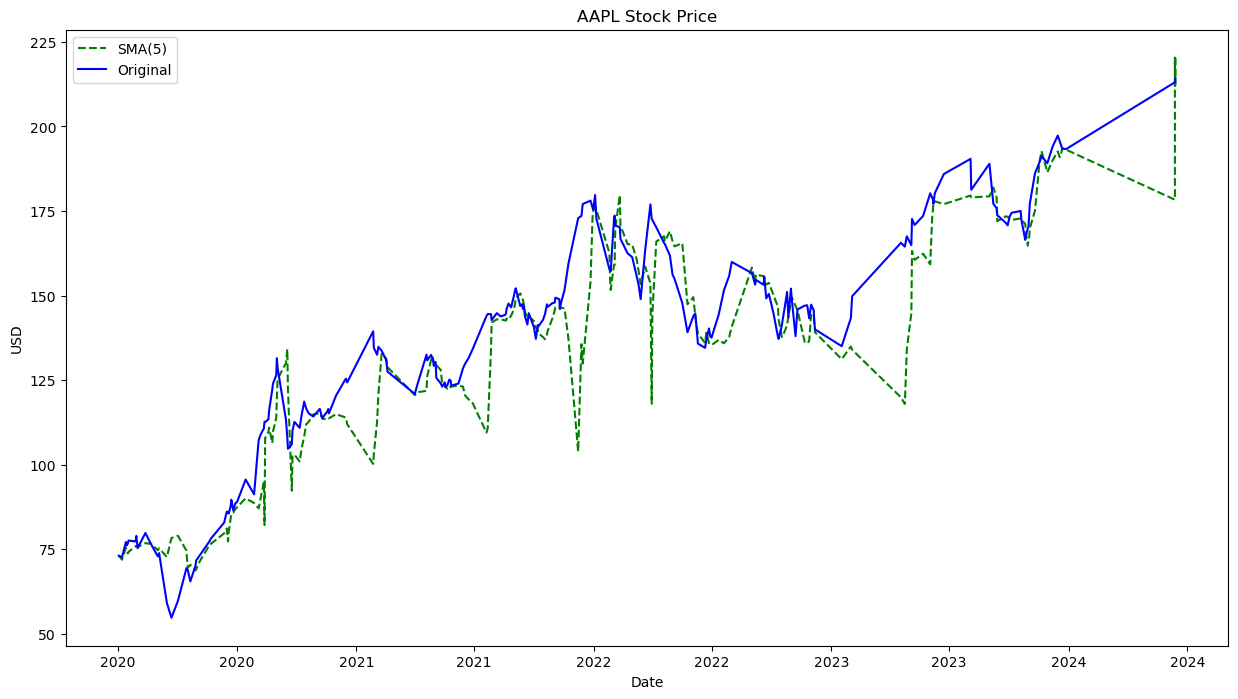

In [150]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(df["Date"], df["SMA(5)"], label="SMA(5)", linestyle="--", color="g")
ax.plot(df["Date"], df["Adj Close"], label="Original", color="b")
ax.set(xlabel="Date",ylabel="USD",title=f"{stk_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.legend()
plt.show()

In [159]:
# Sort the dataframe by the 'Date' column
df = df.sort_values(by='Date')

# Reset the index to keep the dataframe tidy
df = df.reset_index(drop=True)

# Buy and Sell Signals

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [77]:
df=pd.read_csv('final_path')

In [ ]:
# Generate signals based on polarity score and additional filter (SMA)
def generate_signals(df):
    df['SMA'] = df['Close'].rolling(window=20).mean()  # 20-day simple moving average
    df['Signal'] = 0
    df['Signal'] = np.where((df['polarity_score'] > 0) & (df['Close'] > df['SMA']), 1, df['Signal'])
    df['Signal'] = np.where((df['polarity_score'] < 0) & (df['Close'] < df['SMA']), -1, df['Signal'])
    df['Order'] = df['Signal'].diff()
    return df

In [ ]:
# Calculate returns and performance metrics with stop-loss, take-profit, and position sizing
def calculate_performance(df, initial_cash=1000, stop_loss_pct=0.10, take_profit_pct=0.20, position_size_pct=0.20):
    cash = initial_cash
    position = 0
    purchase_price = 0
    portfolio_values = []
    
    for index, row in df.iterrows():
        if row['Order'] == -1 and cash > 0:  # Buy signal
            position = (cash * position_size_pct) / row['Close']
            cash += position * row['Close']
            purchase_price = row['Close']
        elif row['Order'] == 1 and position > 0:  # Sell signal
            cash -= position * row['Close']
            position = 0
        elif position > 0:
            if row['Close'] < purchase_price * (1 - stop_loss_pct):  # Stop-loss condition
                cash += position * row['Close']
                position = 0
                df.loc[index, 'Order'] = -1  # Mark this as a sell due to stop-loss
            elif row['Close'] > purchase_price * (1 + take_profit_pct):  # Take-profit condition
                cash += position * row['Close']
                position = 0
                df.loc[index, 'Order'] = -1  # Mark this as a sell due to take-profit

        portfolio_value = cash + position * row['Close']
        portfolio_values.append(portfolio_value)

    df['Portfolio Value'] = portfolio_values
    final_portfolio_value = portfolio_values[-1]
    returns = df['Portfolio Value'].pct_change().dropna()
    sharpe_ratio = (252**0.5) * returns.mean() / returns.std()  # Assuming 252 trading days in a year
    total_trades = len(df[df['Order'].abs() == 1])
    winning_trades = len(df[(df['Order'] == -1) & (df['Close'] > df['Close'].shift(1))])
    win_ratio = winning_trades / total_trades if total_trades > 0 else 0
    # Calculate maximum drawdown
    rolling_max = df['Portfolio Value'].cummax()
    drawdown = (df['Portfolio Value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.max()

    performance = {
        "Final Portfolio Value": final_portfolio_value,
        "Sharpe Ratio": sharpe_ratio,
        "Number of Trades Executed": total_trades,
        "Win Ratio": win_ratio,
        "Maximum Drawdown": max_drawdown
    }

    return performance



In [ ]:
# Load your dataframe
# Ensure that the 'Date' column is in datetime format and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Generate signals and calculate performance
df = generate_signals(df)
performance = calculate_performance(df)

# Print performance metrics
print(f"Final Portfolio Value: ${performance['Final Portfolio Value']:.2f}")
print(f"Sharpe Ratio: {performance['Sharpe Ratio']:.2f}")
print(f"Number of Trades Executed: {performance['Number of Trades Executed']}")
print(f"Win Ratio: {performance['Win Ratio']:.2f}")
print(f"Maximum Drawdown: {performance['Maximum Drawdown']:.2f}")



In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price')

# Plot buy signals
buy_signals = df[df['Order'] == 1]
plt.plot(buy_signals['Date'], buy_signals['Close'], '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
sell_signals = df[df['Order'] == -1]
plt.plot(sell_signals['Date'], sell_signals['Close'], 'v', markersize=10, color='r', label='Sell Signal')

plt.title('Closing Price and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Portfolio Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()
